In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('가상환경 설정 완료')
print(f'pandas 버전: {pd.__version__}')
print(f'numpy 버전: {np.__version__}')

가상환경 설정 완료
pandas 버전: 2.3.3
numpy 버전: 2.3.5


In [3]:
# 데이터 로드
df = pd.read_csv(r"C:\Users\jeong\anaju\project\ecommerce_analysis\data\raw\online_retail.csv")
print(df.shape)
df.info()
df.head()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 각 컬럼 확인

| InvoiceNo(송장 번호) : 문자열 기반 식별자(ID)로 보이며, 연산 대상 아님             
| StockCode(상품 코드) : 문자/숫자 혼합  → object 타입 적절                        
| Description(상품 설명) : 일부 결측치 존재                       
| Quantity(구매 수량) : 음수 여부 및 반품 가능성 확인 필요        
| InvoiceDate(거래 날짜) : object 타입 → datetime 변환 필요    
| UnitPrice(단가) : 음수/0 값 존재 여부 확인 필요            
| CustomerID(고객 ID) : 결측치 다수 존재 → 비회원 구매인지 확인 필요        
| Country(국가) : 국가별 분포 확인 필요     

### 결측치 상세 내용
- Description 컬럼에 일부 결측치가 존재하며,
이는 코드는 있는데 상품 정보 매핑 누락인지 확인 필요
- CustomerID는 식별자 역할이므로 float 타입보다는
결측치 처리 후 정수형 또는 문자열 타입으로 변환하는 것이 적절할 것 같음



In [4]:
# 결측치 개수 & 비율
print(df.isnull().sum()[df.isnull().sum()>0])
print('-'*30)
print(df.isnull().mean()[df.isnull().mean()>0].round(4))

# CustomerID 널값 27% -> 제거가 아닌 분석 목적에 따라 해결하기
# 회원이 아닌 비회원이라 고객번호 없을 가증성 확인 필요

Description      1454
CustomerID     135080
dtype: int64
------------------------------
Description    0.0027
CustomerID     0.2493
dtype: float64


In [5]:
# 중복 데이터 확인
print(f'완전 중복 행 개수: {df.duplicated().sum():,}')
# df[df.duplicated(keep=False)].sort_values(df.columns.tolist())


완전 중복 행 개수: 5,268


완전 중복 행은 일반적으로 데이터 오류로 간주되지만,
동일 송장 내 동일 상품을 여러 개 구매한 경우
이벤트 단위로 기록되었을 가능성도 존재한다.
따라서 본 분석에서는 원본 데이터의 중복을 직접 제거하기보다,
분석 목적에 맞는 단위(주문/상품)로 집계하여 사용하였다.

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
Quantity 음수: 10,624건
UnitPrice 음수: 2건


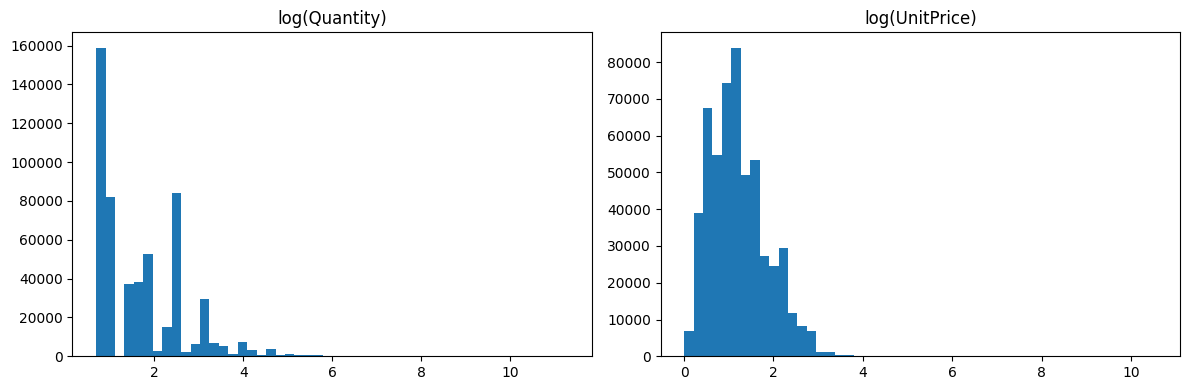

In [6]:
# 수치형 데이터 이상치 확인 
#CustomerID는 식별자이므로 제외

print(df.describe()) 
print(f"Quantity 음수: {(df['Quantity'] < 0).sum():,}건")
print(f"UnitPrice 음수: {(df['UnitPrice'] < 0).sum():,}건")
# 판매 수량, 단가 둘 다 음수 존재
# 수량이 음수인건 반품인거 같은데, 단가가 음수인건 오류인 것 같다.

# df[['Quantity','UnitPrice']].hist()
# 극단적인 이상치때문에 한 곳에 몰려 보임 -> 로그 변환  분포 확인 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['Quantity'].clip(lower=1).apply(np.log1p), bins=50)
axes[0].set_title('log(Quantity)')
axes[1].hist(df['UnitPrice'].clip(lower=0).apply(np.log1p), bins=50)
axes[1].set_title('log(UnitPrice)')

plt.tight_layout()
plt.show()



In [7]:
# CustomerID 
print(f"고유 고객 수: {df['CustomerID'].nunique():,}명")
print(f"CustomerID 있는 거래: {df['CustomerID'].notna().sum():,}건")
print(f"CustomerID 없는 거래: {df['CustomerID'].isna().sum():,}건")

# 고객당 평균 구매 횟수
customer_orders = df[df['CustomerID'].notna()].groupby('CustomerID').size()
print(f"고객당 평균 구매 횟수: {customer_orders.mean():.1f}회")
print(f"1회만 구매한 고객: {(customer_orders == 1).sum():,}명")

고유 고객 수: 4,372명
CustomerID 있는 거래: 406,829건
CustomerID 없는 거래: 135,080건
고객당 평균 구매 횟수: 93.1회
1회만 구매한 고객: 79명


In [8]:
# InvoiceDate 날짜 타입 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"시작일: {df['InvoiceDate'].min()}")
print(f"종료일: {df['InvoiceDate'].max()}")
print(f"기간: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days}일")

# 월별 거래량
monthly = df.groupby(df['InvoiceDate'].dt.to_period('M')).size()
print(monthly)

시작일: 2010-12-01 08:26:00
종료일: 2011-12-09 12:50:00
기간: 373일
InvoiceDate
2010-12    42481
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35284
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25525
Freq: M, dtype: int64


In [9]:
# InvoiceNo 문자열이므로 정규식 값 확인하기
df[df['InvoiceNo'].str.contains(r'[A-Za-z]', na=False)]['InvoiceNo'].unique()
# 거의 C가 포함되어있는데 안보이는 다른 알파벳 있을까봐 다시 확인
print(df['InvoiceNo'].str.extract(r'(^[A-Za-z]+)').value_counts(dropna=False)) #nan이 숫자로만 이루어진 송장

# C로 시작하는 인보이스의 음수 여부 확인 
print(f"'C'로 시작하는 인보이스: {df['InvoiceNo'].astype(str).str.startswith('C').sum():,}건")
cancelled = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"취소 주문 중 음수 Quantity: {(cancelled['Quantity'] < 0).sum():,}건")
# C인보이스는 모두 음수인 것으로 보아 반품 송장 

0  
NaN    532618
C        9288
A           3
Name: count, dtype: int64
'C'로 시작하는 인보이스: 9,288건
취소 주문 중 음수 Quantity: 9,288건


InvoiceNo는 대부분 숫자로만 구성된 정상 주문이었으며,
일부 송장 번호는 문자를 포함하고 있었다.
‘C’로 시작하는 송장은 취소/반품 거래로 해석되고,
‘A’로 시작하는 송장은 3건으로 확인되었다.

In [10]:
# StockCode 확인
print(df['StockCode'].str.extract(r'(^[A-Za-z]+)').value_counts(dropna=False))

# 같은 알파벳의 대소문자 차이는 같은 코드의 중복인지 확인 필요
df[df['StockCode'].isin(['M','m'])][['Description','Quantity','UnitPrice']].head()
# 확인 결과 'M','m'의 description 모두 동일한 Manual인 것으로 보아, 동일한 코드의 중복으로 보임

0        
NaN          538914
POST           1256
DOT             710
M               571
C               144
D                77
S                63
BANK             37
AMAZONFEE        34
gift             34
DCGS             21
CRUK             16
DCGSSGIRL        13
DCGSSBOY         11
PADS              4
B                 3
m                 1
Name: count, dtype: int64


,Description,Quantity,UnitPrice
2239,Manual,1,1.25
2250,Manual,1,18.95
5684,Manual,1,2.55
6798,Manual,2,0.85
7976,Manual,12,0.42



StockCode 컬럼을 확인한 결과,
여러 코드로 상품을 구분하는 것 같고, 
배송비, 수수료, 증정 등의 특정 거래를 나타내는 특수 코드도 있는 것으로 보인다.
또한 대소문자 차이(M/m)로 표현된 코드가 존재하여, 동일 코드 여부를 확인하였다.


In [13]:
# Country 국가별 거래 분포 확인
print(df['Country'].value_counts().head(10))

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64


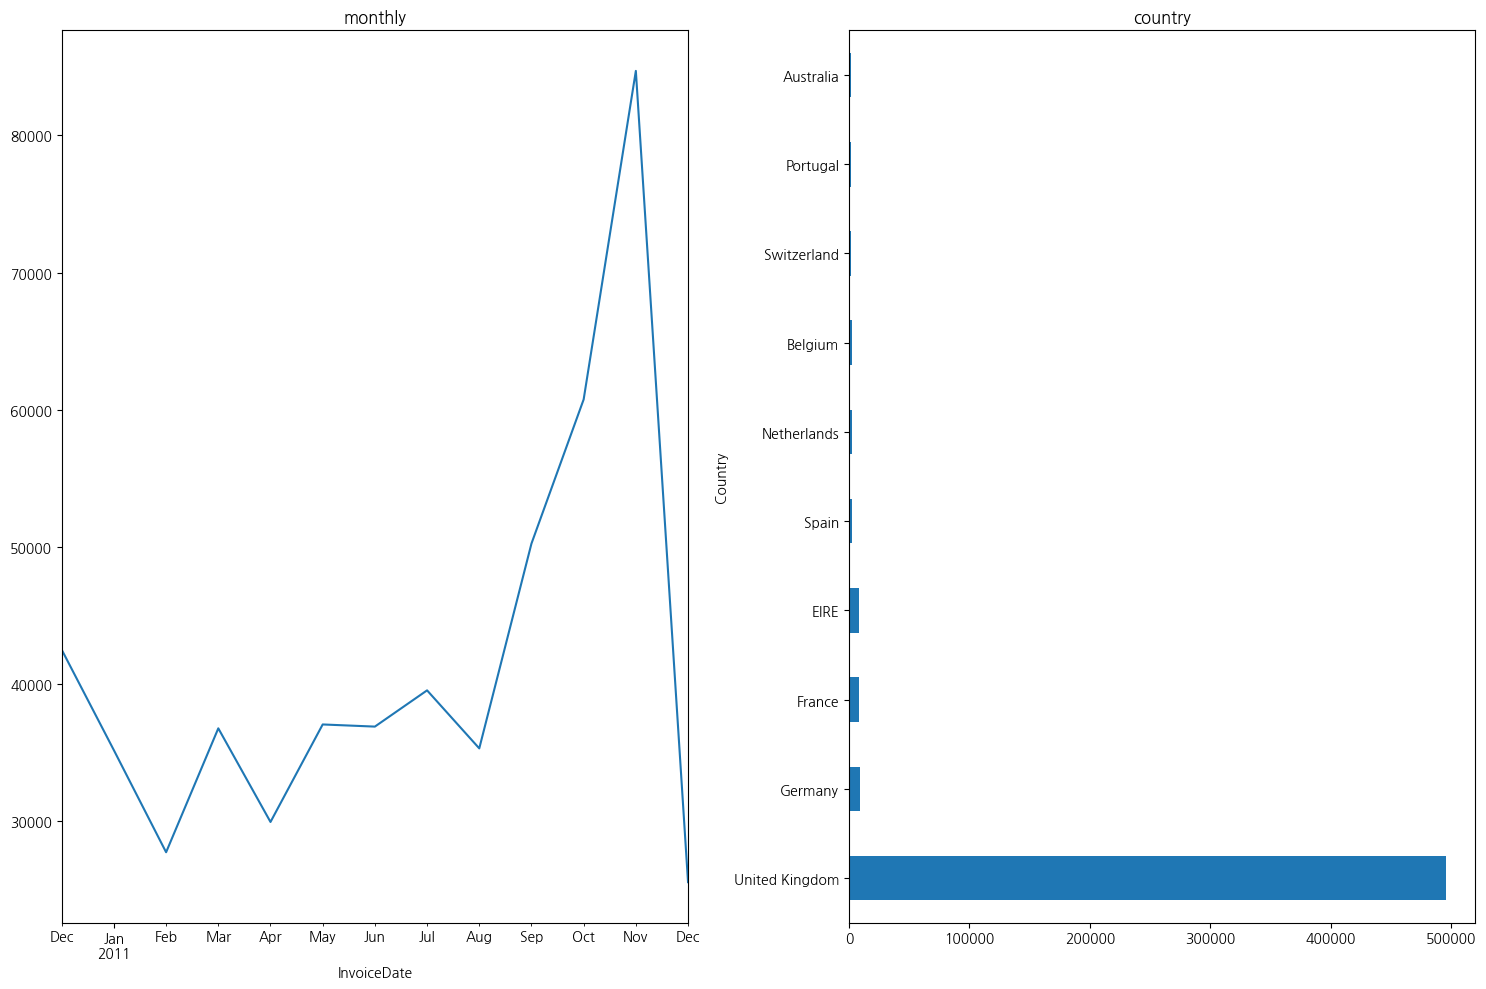

In [18]:
# 시각화

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# 1. 월별 거래량
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M')).size()
monthly_sales.plot(ax=axes[0], title='monthly')

# 2. 국가별 거래량 (Top 10)
df['Country'].value_counts().head(10).plot(kind='barh', ax=axes[1], title='country')


plt.tight_layout()
plt.savefig('../docs/eda_summary.png', dpi=100)
plt.show()